In [7]:
import os
import re
from collections import Counter, defaultdict

import numpy as np
import torch
import train as proteo_train
from checkpoint_analysis import get_sex_mutation_age_distribution
from torch_geometric.explain import CaptumExplainer, Explainer, GNNExplainer
from torch_geometric.explain.config import ExplanationType, ModelMode
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt


############### METRICS ################
def fidelity(explainer, explanation):
    """Evaluates the fidelity of an
    :class:`~torch_geometric.explain.Explainer` given an
    :class:`~torch_geometric.explain.Explanation`, as described in the
    `"GraphFramEx: Towards Systematic Evaluation of Explainability Methods for
    Graph Neural Networks" <https://arxiv.org/abs/2206.09677>`_ paper.

    Fidelity evaluates the contribution of the produced explanatory subgraph
    to the initial prediction, either by giving only the subgraph to the model
    (fidelity-) or by removing it from the entire graph (fidelity+).
    The fidelity scores capture how good an explainable model reproduces the
    natural phenomenon or the GNN model logic.


    For **model** explanations, the fidelity scores are given by:

    .. math::
        \textrm{fid}_{+} &= 1 - \frac{1}{N} \sum_{i = 1}^N
        \mathbb{1}( \hat{y}_i^{G_{C \setminus S}} = \hat{y}_i)

        \textrm{fid}_{-} &= 1 - \frac{1}{N} \sum_{i = 1}^N
        \mathbb{1}( \hat{y}_i^{G_S} = \hat{y}_i)

    Args:
        explainer (Explainer): The explainer to evaluate.
        explanation (Explanation): The explanation to evaluate.
    """

    node_mask = explanation.get('node_mask')
    edge_mask = explanation.get('edge_mask')
    kwargs = {key: explanation[key] for key in explanation._model_args}

    y = explanation.target #these are the preds from the model

    explain_y_hat = explainer.get_masked_prediction(
        explanation.x,
        explanation.edge_index,
        node_mask,
        edge_mask,
        **kwargs,
    )
    explain_y_hat = explainer.get_target(explain_y_hat)

    complement_y_hat = explainer.get_masked_prediction(
        explanation.x,
        explanation.edge_index,
        1.0 - node_mask if node_mask is not None else None,
        1.0 - edge_mask if edge_mask is not None else None,
        **kwargs,
    )
    complement_y_hat = explainer.get_target(complement_y_hat)

    # TODO: Check if I need this part
    if explanation.get('index') is not None:
        y = y[explanation.index]
        if explainer.explanation_type == ExplanationType.phenomenon:
            y_hat = y_hat[explanation.index]
        explain_y_hat = explain_y_hat[explanation.index]
        complement_y_hat = complement_y_hat[explanation.index]

    # Changed this for regression definition
    if explainer.explanation_type == ExplanationType.model:
        # You want pos_fidelity to be as high as possible, big difference between complement_y_hat and y when you remove the subgraph
        pos_fidelity = torch.nn.functional.mse_loss(complement_y_hat, y)
        # You want neg_fidelity to be as low as possible
        neg_fidelity = torch.nn.functional.mse_loss(explain_y_hat, y)

    return float(pos_fidelity), float(neg_fidelity), y


def characterization_score(pos_fidelity, neg_fidelity, pos_weight=0.5, neg_weight=0.5):
    # TODO: Redefine this for regression
    """Returns the componentwise characterization score as described in the
    `"GraphFramEx: Towards Systematic Evaluation of Explainability Methods for
    Graph Neural Networks" <https://arxiv.org/abs/2206.09677>`_ paper.

    ..  math::
       \textrm{charact} = \frac{w_{+} + w_{-}}{\frac{w_{+}}{\textrm{fid}_{+}} +
        \frac{w_{-}}{1 - \textrm{fid}_{-}}}

    Args:
        pos_fidelity (torch.Tensor): The positive fidelity
            :math:`\textrm{fid}_{+}`.
        neg_fidelity (torch.Tensor): The negative fidelity
            :math:`\textrm{fid}_{-}`.
        pos_weight (float, optional): The weight :math:`w_{+}` for
            :math:`\textrm{fid}_{+}`. (default: :obj:`0.5`)
        neg_weight (float, optional): The weight :math:`w_{-}` for
            :math:`\textrm{fid}_{-}`. (default: :obj:`0.5`)
    """
    if (pos_weight + neg_weight) != 1.0:
        raise ValueError(f"The weights need to sum up to 1 " f"(got {pos_weight} and {neg_weight})")

    numer = neg_weight + pos_weight
    denom = (neg_weight / neg_fidelity) + (pos_weight / (1.0 / pos_fidelity))
    return numer / denom


############### FUNCTIONS ################
def load_config(module):
    '''Load the config from the module  and return it'''
    config = module.config
    # Check if 'use_master_nodes' attribute exists, added for runs with master nodes
    if not hasattr(config, 'use_master_nodes'):
        # Add the attribute with a default value (e.g., False)
        setattr(config, 'use_master_nodes', False)
    return config


# Load model checkpoint - Note when the wrapper class is not necessary you can use this function from checkpoint_analysis.py
def load_checkpoint(relative_checkpoint_path):
    '''Load the checkpoint as a module. Note levels_up depends on the directory structure of the ray_results folder'''
    # Construct the full path to the checkpoint
    checkpoint_path = os.path.join(relative_checkpoint_path, 'checkpoint.ckpt')
    print("checkpoint_path", checkpoint_path)

    # Check if the file exists to avoid errors
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # Load the checkpoint dictionary using PyTorch directly to modify the config
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    # Ensure that the 'use_master_nodes' attribute is in the checkpoint's config
    if not hasattr(checkpoint['hyper_parameters']['config'], 'use_master_nodes') or not hasattr(
        checkpoint['hyper_parameters']['config'], 'master_nodes'
    ):
        checkpoint['hyper_parameters']['config'].use_master_nodes = False  # Add default value
        checkpoint['hyper_parameters']['config'].master_nodes = []

    torch.save(checkpoint, checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    module = proteo_train.Proteo.load_from_checkpoint(checkpoint_path)

    original_forward = module.model.forward

    # Redefine the forward method of module.model to return only pred
    def new_forward(self, x, edge_index=None, data=None):
        pred, _ = original_forward(x, edge_index, data)
        return pred

    module.model.forward = new_forward.__get__(module.model)
    return module


def run_explainer_fidelity_single_dataset(dataset, explainer):
    # Run explainer on each person in dataset and find fidelity and characterization score
    n_nodes = len(dataset[0].x)
    n_people = len(dataset)
    print(f"n_people = {n_people}")
    print(f"n_nodes = {n_nodes}")

    all_fidelity_plus = []
    all_fidelity_minus = []
    all_y_preds = []
    all_characterization_scores = []
    for data in dataset:
        # Ensure data.x and data.edge_index are tensors
        if not isinstance(data.x, torch.Tensor) or not isinstance(data.edge_index, torch.Tensor):
            raise TypeError("data.x and data.edge_index must be torch.Tensor")
        explanation = explainer(data.x, data.edge_index, data=data, target=None, index=None)
        fidelity_plus, fidelity_minus, y_preds = fidelity(explainer, explanation)
        all_fidelity_plus.append(fidelity_plus)
        all_fidelity_minus.append(fidelity_minus)
        all_y_preds.extend(y_preds.flatten().cpu())
        characterization_score_val = characterization_score(fidelity_plus, fidelity_minus)
        all_characterization_scores.append(characterization_score_val)

    return (
        np.array(all_fidelity_plus),
        np.array(all_fidelity_minus),
        np.array(all_characterization_scores),
        np.array(all_y_preds)
    )


def fidelity_per_subgroup_train_and_test(checkpoint_path, train_mse, val_mse):
    module = load_checkpoint(checkpoint_path)
    config = load_config(module)
    
    # Load datasets
    train_dataset, test_dataset = proteo_train.construct_datasets(config)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset.to(device)
    test_dataset.to(device)
    train_y = np.array((train_dataset.y).cpu())
    test_y = np.array((test_dataset.y).cpu())

    # Construct Explainer and set parameters
    explainer = Explainer(
        model=module.model.to(device),
        algorithm=CaptumExplainer('IntegratedGradients'),
        explanation_type='model',
        model_config=dict(
            mode='regression',
            task_level='graph',  # Explain why the model predicts a certain property or label for the entire graph (nodes + edges)
            return_type='raw',
        ),
        node_mask_type='attributes',  # 'object', # Generate masks that indicate the importance of individual node features
        edge_mask_type=None,
        threshold_config=dict(  # Keep only the top 300 most important proteins and set the rest to 0
            threshold_type='hard',  # Hard threshold is applied to each mask. The elements of the mask with a value below the value are set to 0, the others are set to 1
            value=0.01,
        ),
    )

    # Run explainer on each person in dataset and find fidelity and characterization score for train and test
    (
        train_fidelity_plus,
        train_fidelity_minus,
        train_characterization_scores,
        train_y_preds
    ) = run_explainer_fidelity_single_dataset(train_dataset, explainer)
    (
        test_fidelity_plus,
        test_fidelity_minus,
        test_characterization_scores,
        test_y_preds
    ) = run_explainer_fidelity_single_dataset(test_dataset, explainer)

    # Define subgroups
    sex_labels = ['M', 'F']
    mutation_labels = ["C9orf72", "MAPT", "GRN", "CTL"]

    # Get characteristics of each person in the dataset
    (
        train_sex_labels,
        test_sex_labels,
        train_mutation_labels,
        test_mutation_labels,
        _,  # Removing age labels
        _,
    ) = get_sex_mutation_age_distribution(config)

    # Compute fidelity and characterization score for each subgroup
    train_fidelity_results = {}
    test_fidelity_results = {}

    for sex in sex_labels:
        for mutation in mutation_labels:
            subgroup_name = f"{sex}_{mutation}"

            # Create mask for current subgroup
            train_mask = (train_sex_labels == sex) & (train_mutation_labels == mutation)
            test_mask = (test_sex_labels == sex) & (test_mutation_labels == mutation)

            # Filter predictions and targets based on mask for train
            train_subgroup_fid_plus = train_fidelity_plus[train_mask]
            train_subgroup_fid_minus = train_fidelity_minus[train_mask]
            train_subgroup_y = train_y[train_mask]
            train_subgroup_y_preds = train_y_preds[train_mask]
            train_subgroup_mse = np.mean((train_subgroup_y - train_subgroup_y_preds) ** 2)
            train_characterization_score = train_characterization_scores[train_mask]

            # Filter predictions and targets based on mask for test
            test_subgroup_fid_plus = test_fidelity_plus[test_mask]
            test_subgroup_fid_minus = test_fidelity_minus[test_mask]
            test_subgroup_y = test_y[test_mask]
            test_subgroup_y_preds = test_y_preds[test_mask]
            test_subgroup_mse =np.mean((test_subgroup_y - test_subgroup_y_preds) ** 2)
            test_characterization_score = test_characterization_scores[test_mask]

            # Compute avg if there are any samples in the subgroup
            if len(train_subgroup_fid_plus) > 0:
                train_fidelity_results[subgroup_name] = (
                    np.mean(train_subgroup_fid_plus) / train_mse,
                    np.mean(train_subgroup_fid_minus) / train_mse,
                    np.mean(train_characterization_score),
                    np.mean(train_subgroup_fid_plus - train_subgroup_fid_minus),
                    np.mean(train_subgroup_fid_plus) / train_subgroup_mse,
                    np.mean(train_subgroup_fid_minus) / train_subgroup_mse,
                    #train_subgroup_fid_plus,
                    #train_subgroup_fid_minus,
                    #train_subgroup_fid_plus / train_mse,
                    #train_subgroup_fid_minus / train_mse,
                    #train_characterization_score,
                    #train_subgroup_fid_plus - train_subgroup_fid_minus,
                    #train_subgroup_fid_plus / train_subgroup_mse,
                    #train_subgroup_fid_minus / train_subgroup_mse,
                )
            else:
                train_fidelity_results[subgroup_name] = "No samples in subgroup"

            if len(test_subgroup_fid_plus) > 0:
                test_fidelity_results[subgroup_name] = (
                    np.mean(test_subgroup_fid_plus) / val_mse,
                    np.mean(test_subgroup_fid_minus) / val_mse,
                    np.mean(test_characterization_score),
                    np.mean(test_subgroup_fid_plus - test_subgroup_fid_minus),
                    np.mean(test_subgroup_fid_plus) / test_subgroup_mse,
                    np.mean(test_subgroup_fid_minus) / test_subgroup_mse,
                    #test_subgroup_fid_plus,
                    #test_subgroup_fid_minus,
                    #test_subgroup_fid_plus / val_mse,
                    #test_subgroup_fid_minus / val_mse,
                    #test_characterization_score,
                    #test_subgroup_fid_plus - test_subgroup_fid_minus,
                    #test_subgroup_fid_plus / test_subgroup_mse,
                    #test_subgroup_fid_minus / test_subgroup_mse,
                )
            else:
                test_fidelity_results[subgroup_name] = "No samples in subgroup"

    return train_fidelity_results, test_fidelity_results



def plot_three_dicts(dict1, dict2, dict3, mode='train'):
    # Dynamically generate titles based on the mode
    titles1 = [
        f'np.mean({mode}_subgroup_fid_plus) / {mode}_mse',
        f'np.mean({mode}_subgroup_fid_minus) / {mode}_mse',
        f'np.mean({mode}_characterization_score)',
        f'np.mean({mode}_subgroup_fid_plus - {mode}_subgroup_fid_minus)',
        f'np.mean({mode}_subgroup_fid_plus) / {mode}_subgroup_mse',
        f'np.mean({mode}_subgroup_fid_minus) / {mode}_subgroup_mse'
    ]

    titles2 = [
        f'{mode}_subgroup_fid_plus',
        f'{mode}_subgroup_fid_minus',
        f'{mode}_subgroup_fid_plus / {mode}_mse',
        f'{mode}_subgroup_fid_minus / {mode}_mse',
        f'{mode}_characterization_score',
        f'{mode}_subgroup_fid_plus - {mode}_subgroup_fid_minus',
        f'{mode}_subgroup_fid_plus / {mode}_subgroup_mse',
        f'{mode}_subgroup_fid_minus / {mode}_subgroup_mse'
    ]

    # Create subplots for the first 6 scalar values across all keys
    fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for a total of 6 subplots
    fig1.suptitle(f'Histograms of Scalar Values (First 6 Positions) - {mode.title()}', fontsize=16)

    # Plot the first 6 histograms for scalar values across all keys
    for i in range(6):
        values_dict1 = [values[i] for values in dict1.values()]
        values_dict2 = [values[i] for values in dict2.values()]
        values_dict3 = [values[i] for values in dict3.values()]
        if i == 3:
            print("values_dict1", values_dict1)
            print("values_dict2", values_dict2)
            print("values_dict3", values_dict3)

        ax = axs1[i // 3, i % 3]  # Access subplot based on loop index
        ax.hist(values_dict1, bins=10, alpha=0.5, label='Not personalized')
        ax.hist(values_dict2, bins=10, alpha=0.5, label='Personalized fc')
        ax.hist(values_dict3, bins=10, alpha=0.5, label='Personalized master nodes')
        ax.set_title(titles1[i])  # Set the dynamic title from titles1 list
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

    # Create a single figure for the next 9 histograms for list values (6th to 14th positions)
    fig2, axs2 = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns for a total of 9 subplots
    fig2.suptitle(f'Histograms of List Values (6th to 14th Positions) - {mode.title()}', fontsize=16)

    # Plot histograms for each list position (6th to 14th) aggregated across all keys
    for i in range(6, 14):
        combined_lst1 = [item for key in dict1.keys() for item in dict1[key][i]]
        combined_lst2 = [item for key in dict2.keys() for item in dict2[key][i]]
        combined_lst3 = [item for key in dict3.keys() for item in dict3[key][i]]

        ax = axs2[(i-6) // 3, (i-6) % 3]  # Access subplot based on loop index
        ax.hist(combined_lst1, bins=10, alpha=0.5, label='Not personalized')
        ax.hist(combined_lst2, bins=10, alpha=0.5, label='Personalized fc')
        ax.hist(combined_lst3, bins=10, alpha=0.5, label='Personalized master nodes')
        ax.set_title(titles2[i-6])  # Set the dynamic title from titles2 list
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


In [6]:
checkpoint_path = '/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-13_15-49-20/model=gat-v4,seed=31061_269_act=sigmoid,adj_thresh=0.1000,batch_size=8,dropout=0.1000,l1_lambda=0.0008,lr=0.0000,lr_scheduler=Lamb_2024-08-13_16-58-56/checkpoint_000005'
train_fidelity_results_personalized, test_fidelity_results_personalized = fidelity_per_subgroup_train_and_test(
    checkpoint_path,  0.617820680141449, 0.29270920157432556
)
print("Train personalized fidelity results fully connected")
print(train_fidelity_results_personalized)
#print("Test personalized fidelity results fully connected")
#print(test_fidelity_results_personalized)

    
checkpoint_path = '/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-15_10-15-54/model=gat-v4,seed=4565_459_act=elu,adj_thresh=0.7000,batch_size=32,dropout=0,l1_lambda=0.0644,lr=0.0000,lr_scheduler=ReduceLROnPla_2024-08-15_12-16-06/checkpoint_000000'
train_fidelity_results, test_fidelity_results = fidelity_per_subgroup_train_and_test(
        checkpoint_path, 1.0415549278259277, 0.8367679119110107
)
print("Train fidelity results not personalized")
print(train_fidelity_results)
#print("Test fidelity results not personalized")
#print(test_fidelity_results)

checkpoint_path = '/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-23_13-20-08/model=gat-v4,seed=44609_31_act=relu,adj_thresh=0.9000,batch_size=50,dropout=0,l1_lambda=0.0104,lr=0.0034,lr_scheduler=ReduceLROnPl_2024-08-23_13-20-08/checkpoint_000006'
train_fidelity_results_personalized_master, test_fidelity_results_personalized_master = fidelity_per_subgroup_train_and_test(checkpoint_path, 0.6138961911201477, 0.35898807644844055)
print("Train fidelity results personalized master nodes")
print(train_fidelity_results_personalized_master)




checkpoint_path /scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-13_15-49-20/model=gat-v4,seed=31061_269_act=sigmoid,adj_thresh=0.1000,batch_size=8,dropout=0.1000,l1_lambda=0.0008,lr=0.0000,lr_scheduler=Lamb_2024-08-13_16-58-56/checkpoint_000005/checkpoint.ckpt
Loading data from: /home/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.1_num_nodes_7000_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train.pt
Loading data from: /home/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.1_num_nodes_7000_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_test.pt
n_people = 179
n_nodes = 7000
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None
edge_mask None

KeyboardInterrupt: 

values_dict1 [-4.792774537030389, -5.014885306358337, -5.295805136362712, -5.6593462439144355, -5.190768026536511, -5.399743670508975, -5.525475229535784, -5.402803028331084]
values_dict2 [0.21145519789527445, 0.18101300671696663, 0.27171443154414493, 0.0880619421163026, 0.4011574214504611, 0.22761724960236324, 0.446952434522765, 0.15374564642415328]
values_dict3 [1.530858729001974, 0.9131690604408504, 2.361686342240622, 0.9780001570858436, 1.9290656532309274, 0.4979422904691005, 2.8406193378946876, 1.4507263152541006]


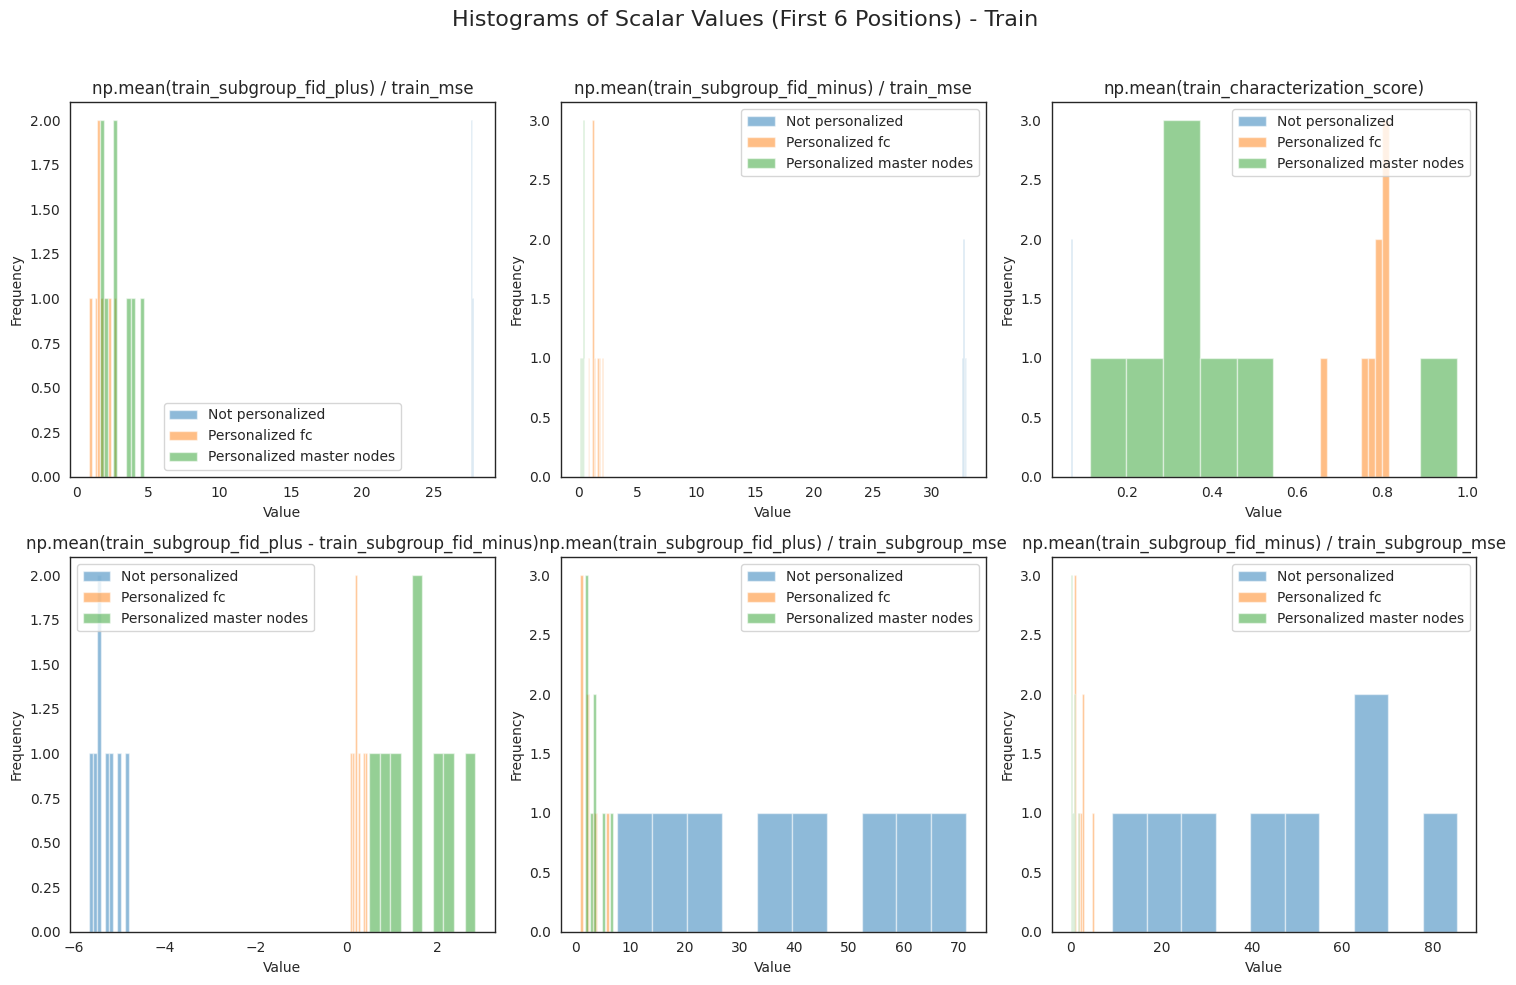

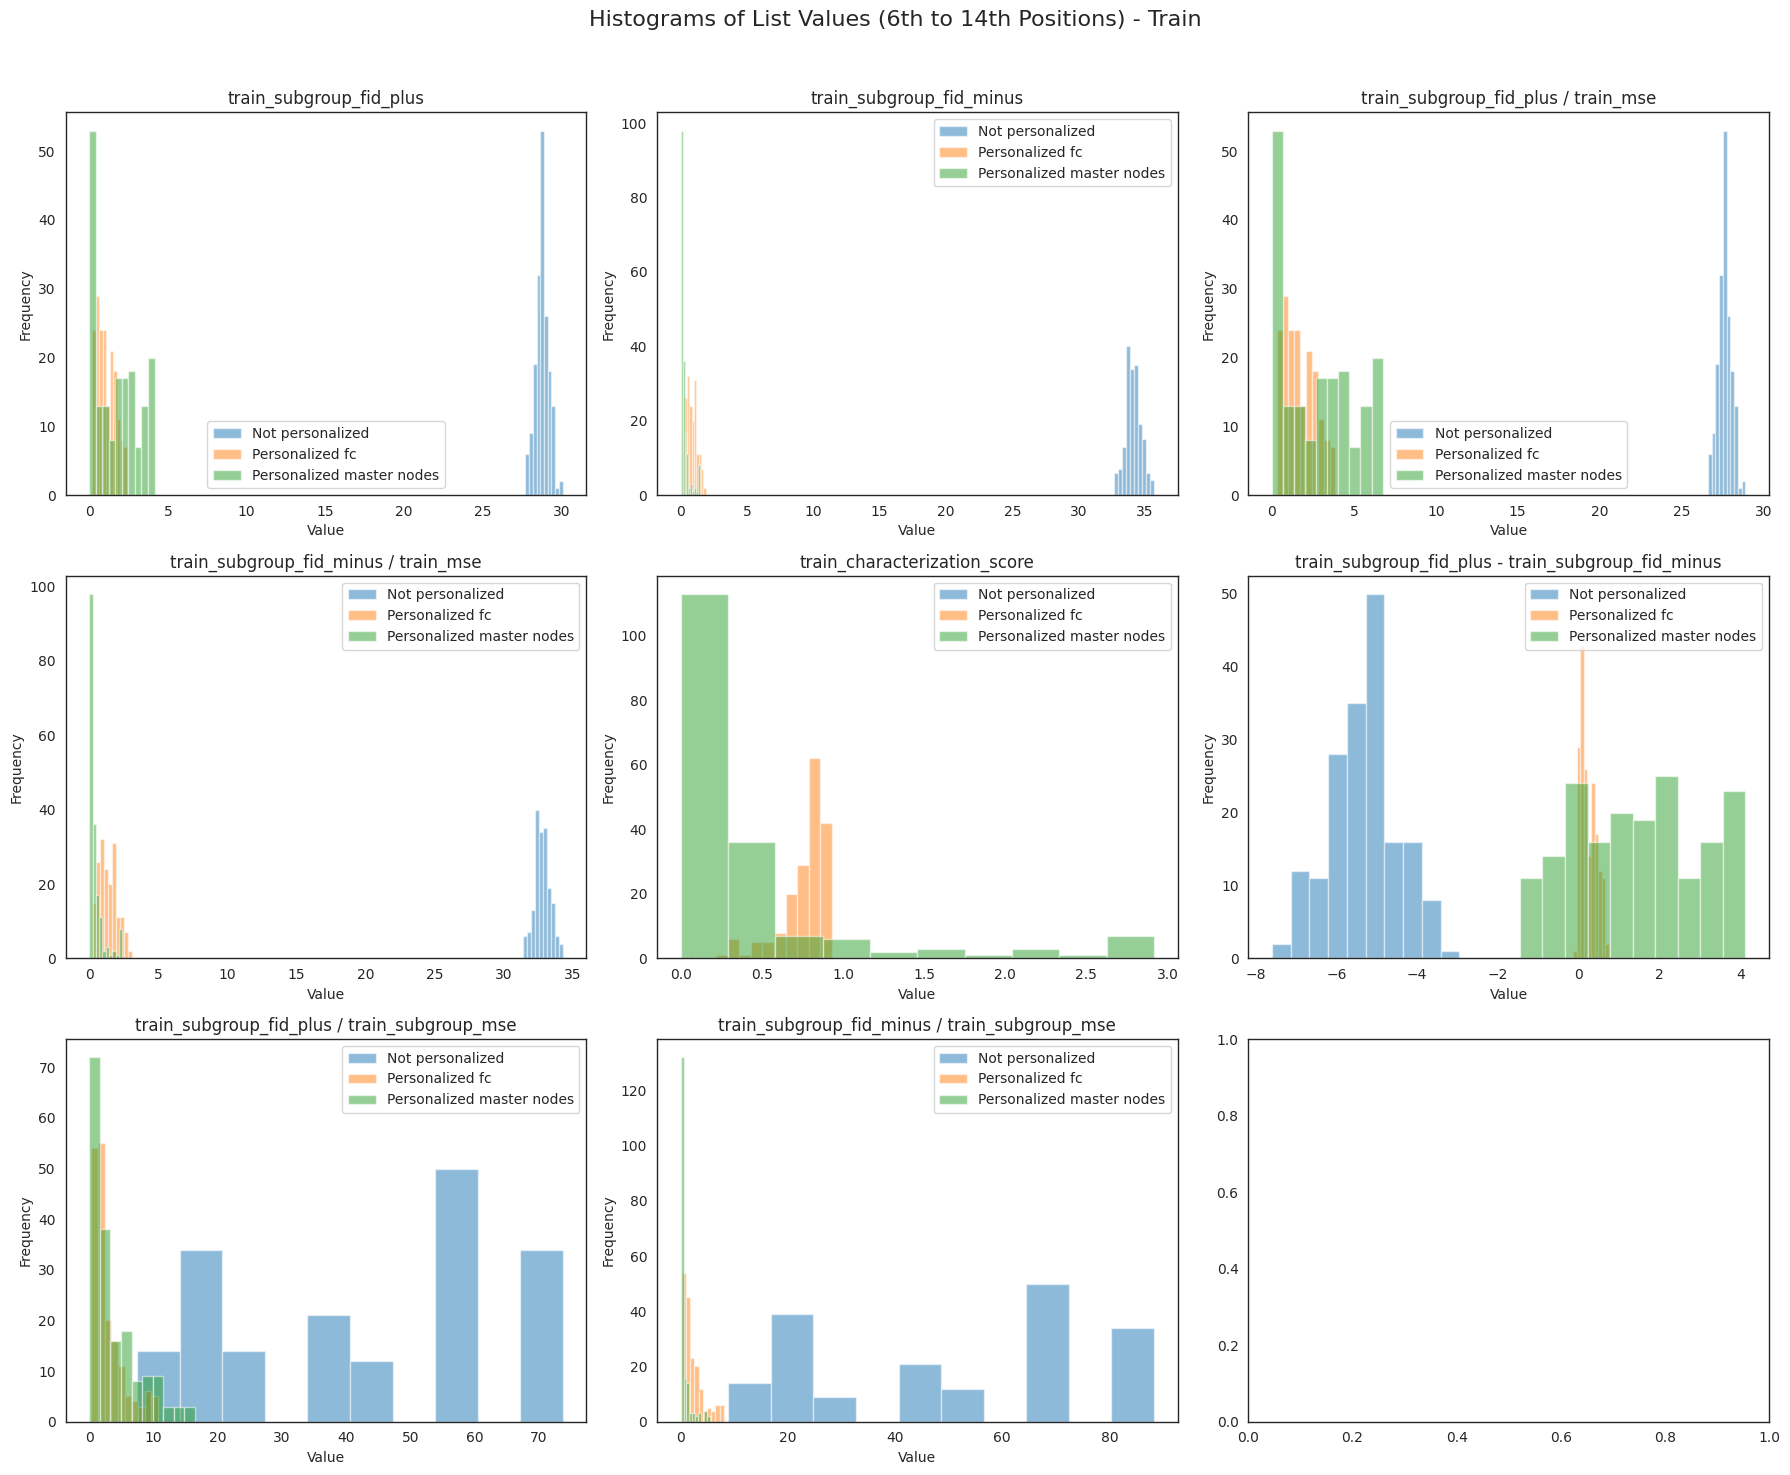

values_dict1 [-5.053719202677409, -4.627917289733887, -4.541786829630534, -5.422412236531575, -5.228764620694247, -5.280398232596261, -4.97016716003418, -5.216688632965088]
values_dict2 [0.21857737501462302, 0.18048207461833954, 0.28142841657002765, 0.07820019125938416, 0.38374797051603143, 0.33688827923366, 0.39767807722091675, 0.17134501785039902]
values_dict3 [1.379004509828519, 1.001465659122914, 2.67713759203131, 1.2441251313624282, 1.8084052623757585, 1.272025521046349, 2.465300275662836, 1.7662974195554852]


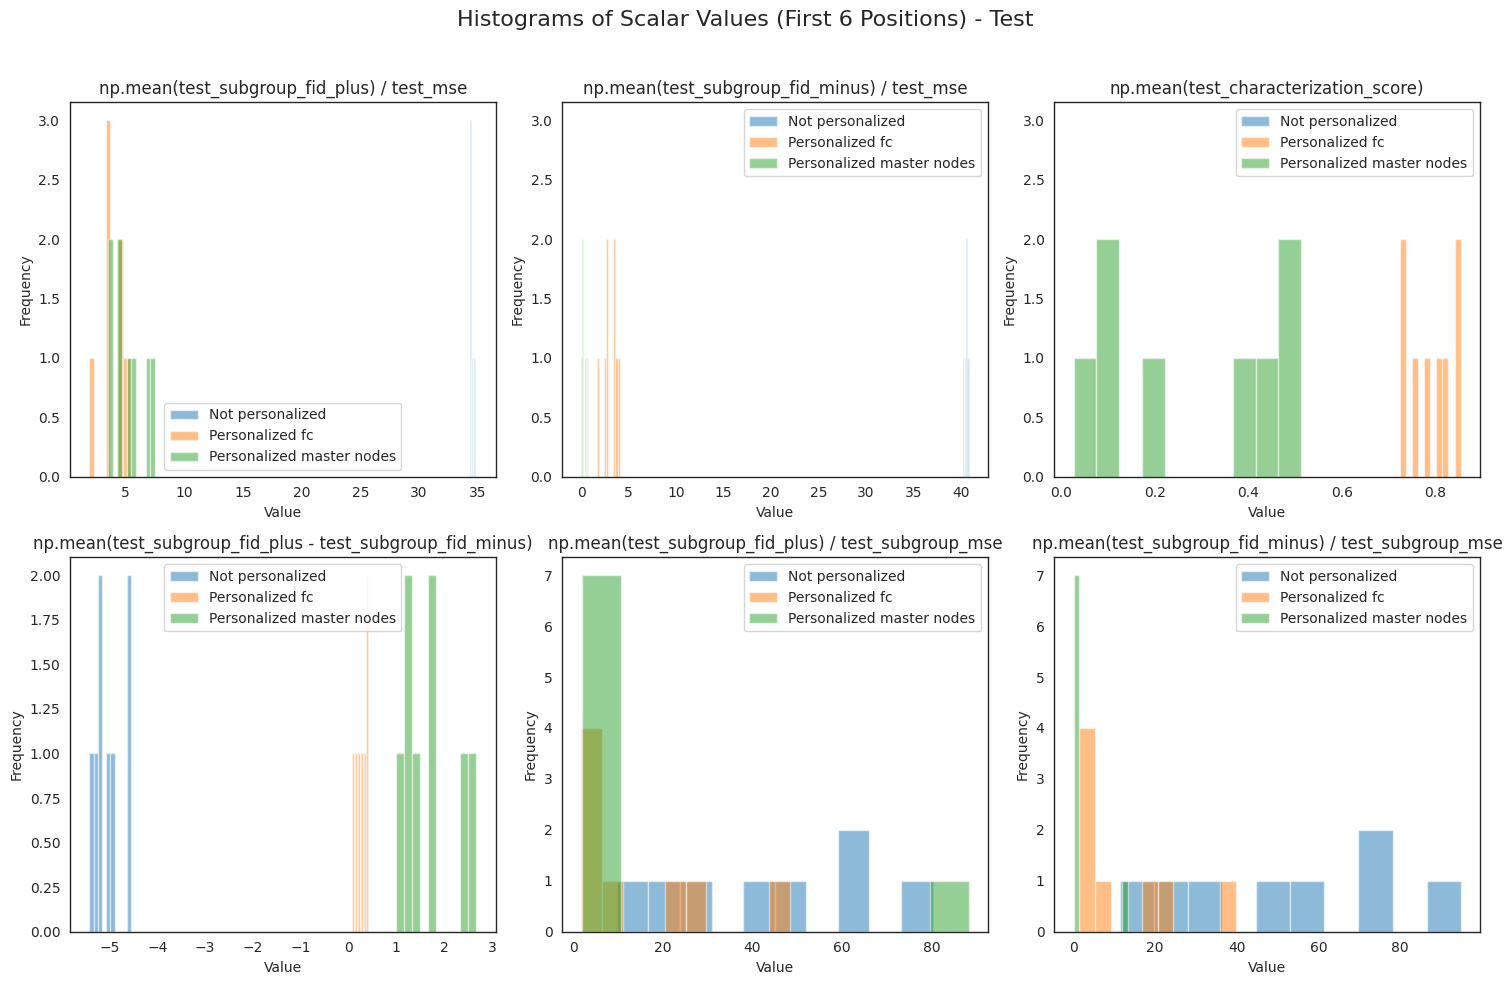

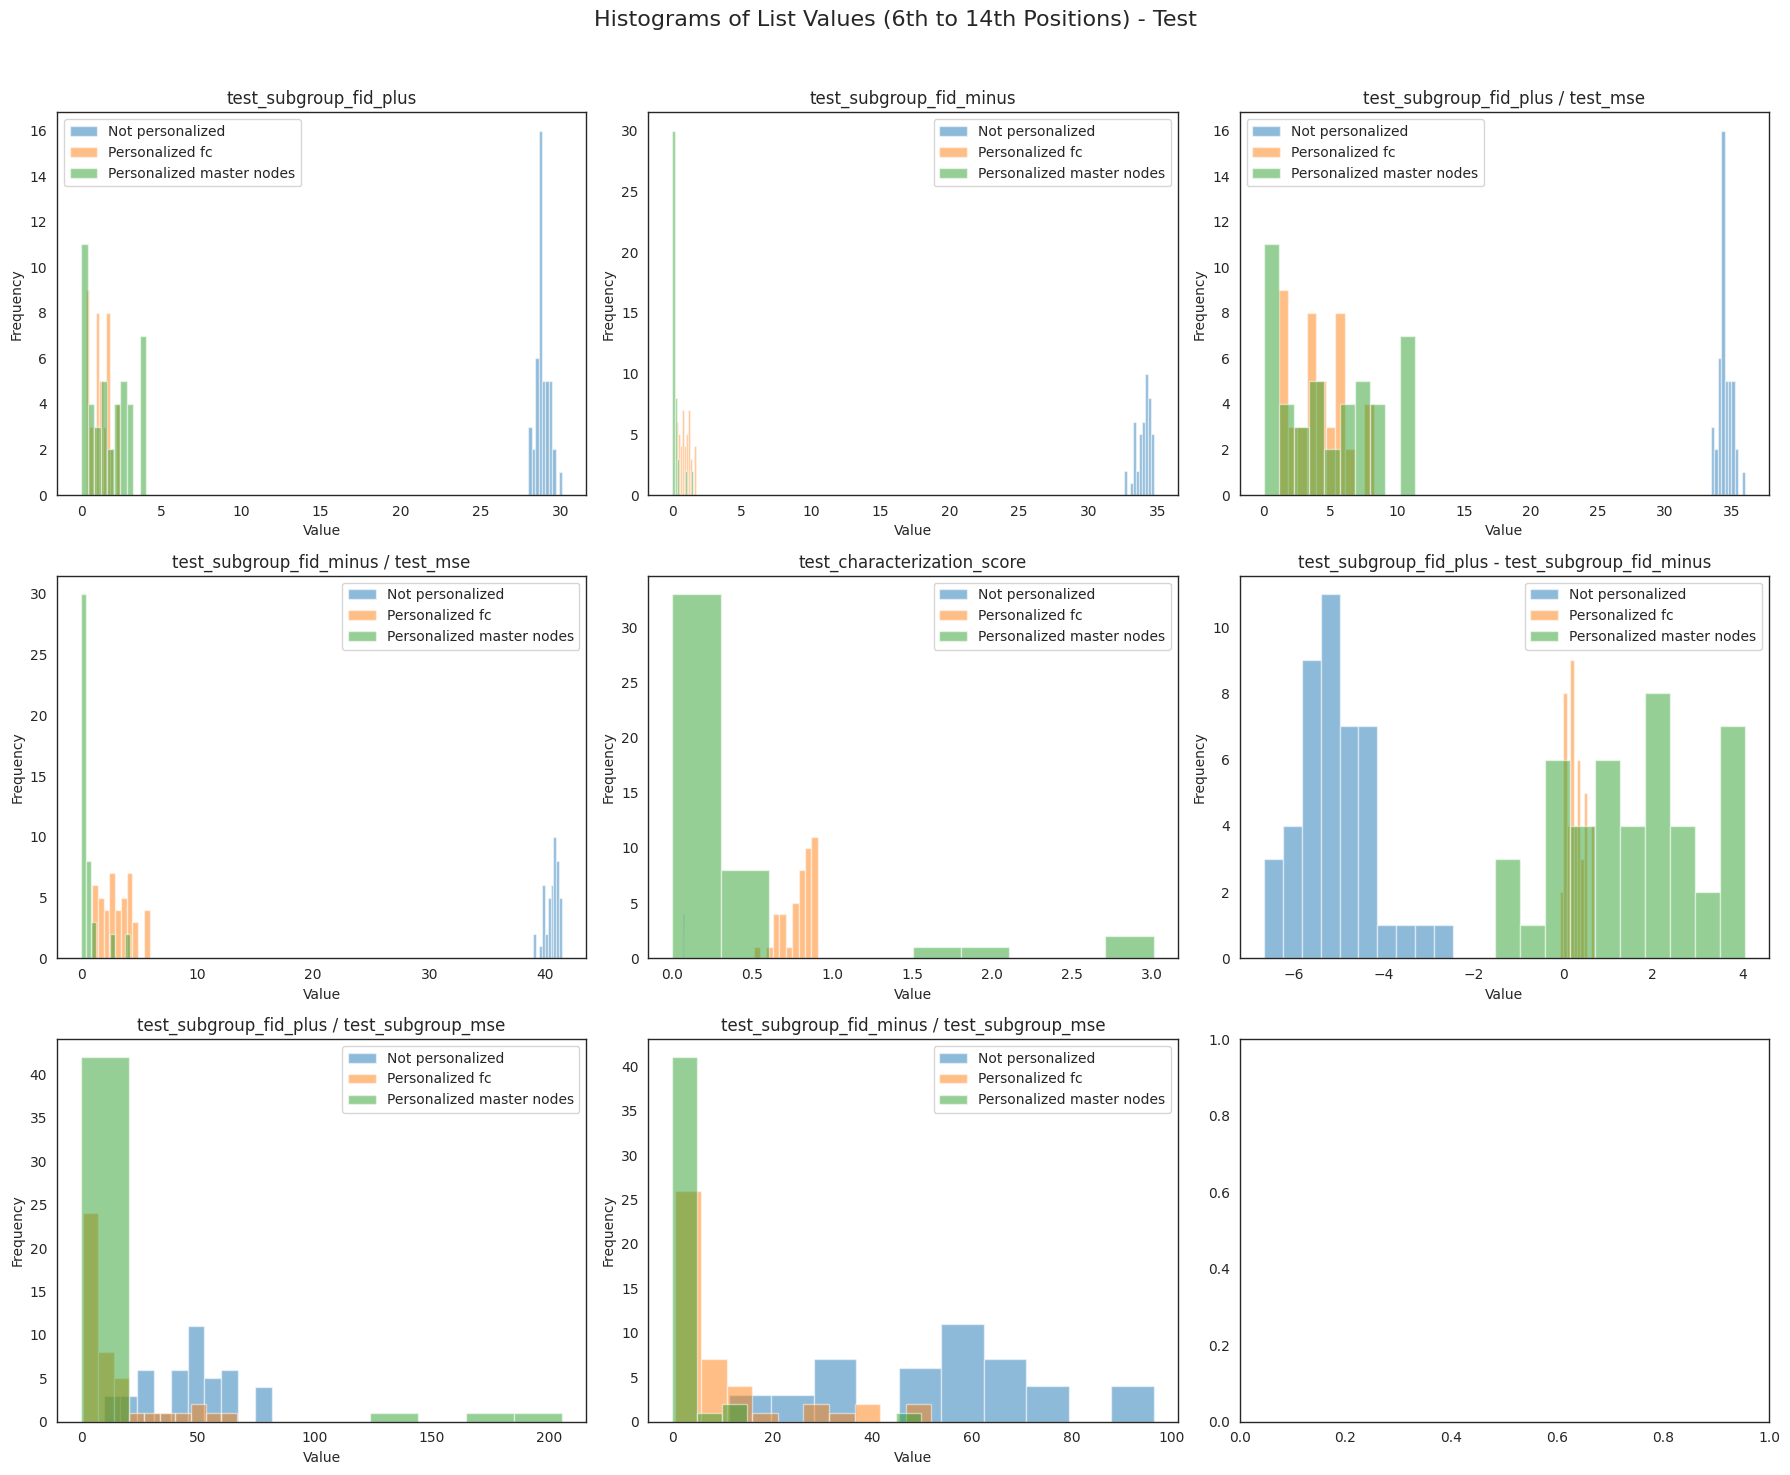

In [12]:
plot_three_dicts(train_fidelity_results, train_fidelity_results_personalized,train_fidelity_results_personalized_master, "train")
plot_three_dicts(test_fidelity_results, test_fidelity_results_personalized,test_fidelity_results_personalized_master,  "test")